## This is a simple program to solve the hydrogen atom using `spin-unpolarized` LDA.

### Dependencies

- `python` 3.11 not necessary
- `numpy` 1.26.4
- `matplotlib` 3.8.4

In [1]:
import numpy as np
from sys import argv
import matplotlib.pyplot as plt

pi = np.pi
NUCLEAR_CHARGE = 1

In [2]:
class Hatom:
    def __init__(self,R_MAX,SAMPLES):


        self.SAMPLES = SAMPLES # # of radial sampling
        self.r = np.linspace(0,R_MAX,SAMPLES)
        self.E_k = 0  #kinetic
        self.total_energy = 0
        self.rho = np.zeros(SAMPLES) #density
        self.V_H = np.zeros(SAMPLES) #hartree
        self.V_X = np.zeros(SAMPLES) #exchange
        self.V_N = np.zeros(SAMPLES) #nuclear potential
        self.V = np.zeros(SAMPLES) #total potential
        self.u = np.zeros(SAMPLES) #radial wavefunction
        self.V_N[1:] = - NUCLEAR_CHARGE / self.r[1:]
        self.V_N[0]=0


        """
        solving the Poisson equation (U_H''(r) = -rho(r) / r) to compute the hartree potential
        boundary conditions: U_H(0) = 0, U_H(r_max) = NUCLEAR_CHARGE    
        """
    def compute_hartree_potential(self):

        U_H = np.zeros(self.SAMPLES)
        U_H[0] = 0
        U_H[1] = 0
        # outwards integration using Verlet algorithm
        step = (self.r[-1] - self.r[0]) / (self.SAMPLES-1)
        for i in range(1,self.SAMPLES-1):
            U_H[i+1] = 2*U_H[i] - U_H[i-1] - step**2 * self.rho[i]/self.r[i]

        # boundary condition
        alpha = (NUCLEAR_CHARGE - U_H[-1]) / self.r[-1]
        U_H = U_H + alpha * self.r

        self.V_H[1:] = U_H[1:] / self.r[1:]
        self.V_H[0] = 0
        
    def compute_exchange_potential(self):
        self.V_X[1:] = -np.cbrt(3*self.rho[1:]/(4*pi**2*self.r[1:]**2)) #Slater Potential
        self.V_X[0] = 0 #otherwise it diverges at 0
        
    
    def compute_total_potential(self):
        self.compute_exchange_potential()
        self.compute_hartree_potential()
        self.V = self.V_N + self.V_H  + self.V_X
        
    def hse_normalize(self): 
        probability_density=self.u**2
        probability = np.trapz(probability_density,self.r) 
        #the probability of finding an electron has to be = 1
        probability_density = probability_density/probability 
        self.u = probability_density**0.5

    def hse_integrate(self, angular_momentum, E_N):
        #using Verlet's algorithm

        L = angular_momentum
        step = (self.r[-1] - self.r[0]) / (self.SAMPLES-1)
        #setting boundary codition
        self.u[-1] = self.r[-1]*np.exp(-self.r[-1])
        self.u[-2]= self.r[-2]*np.exp(-self.r[-2])
        #integrate inward using Verlet algorithm
        for i in range(self.SAMPLES-2,0,-1):
            self.u[i-1] = 2*self.u[i] - self.u[i+1] + step**2*(-2*E_N + 2*self.V[i] + L*(L+1)/self.r[i]**2)*self.u[i]
    
    def hse_solve(self,N,angular_momentum,PREC_HSE,HSE_E_MIN): 
        
        """
        Solves Schrodinger problem with precision PREC_HSE on energy eignvalue,
        the bisection method is used to find the eignvalue.
        """
        L = angular_momentum
        E_N=0
        E_max =  0
        E_min = HSE_E_MIN
        while np.abs(E_max-E_min) > PREC_HSE:
            E_N = (E_min+E_max)/2  #bisection method
            self.hse_integrate(L,E_N) #solve SE
            nodes = 0 #look for nodes
            for i in range(0,self.SAMPLES-1):
                if self.u[i]*self.u[i+1] < 0: nodes+=1
            #continue search in the above or below half of energy range
            if (nodes > N-L-1): E_max = E_N
            else: E_min = E_N 
        self.hse_normalize() #normalize WF
        return E_N
        
    def potential_energy(self, V): 
        return np.trapz(V*self.u**2,self.r)

    def hdft(self,PREC_DFT,PREC_HSE,HSE_E_MIN):
        #Reiterates the solution of the SE,

        last_total_energy = 1
        self.total_energy = 0
        while(np.abs(last_total_energy-self.total_energy)>PREC_DFT):
            last_total_energy = self.total_energy
            self.compute_total_potential()
            #L is always 0 because s orbital, N = 1
            self.E_k = self.hse_solve(1, 0,PREC_HSE,HSE_E_MIN) #N,L
            self.rho = 2*self.u**2 #computes density, 2e- in 1s
            #total energy of the 2 electrons + potential energy
            self.total_energy = 2*self.E_k - self.potential_energy(self.V_H)  - self.potential_energy(self.V_X)/2   
        


Total energy  -3.289  a.u


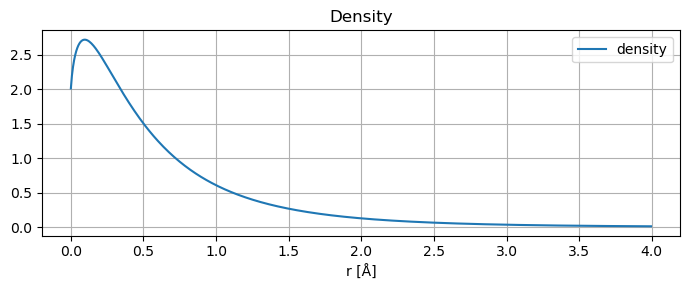

In [4]:
SAMPLES = 4049
R_MAX = 30
PREC_DFT = 1e-4
PREC_HSE = 1e-8
HSE_E_MIN = -20
atom = Hatom(R_MAX, SAMPLES)
atom.hdft(PREC_DFT, PREC_HSE, HSE_E_MIN)
print("Total energy ",round(atom.total_energy, 3)," a.u")


fig, ax = plt.subplots(figsize=(7,3))
ax.plot(atom.r[atom.r<4],atom.rho[atom.r<4],label='density')
ax.set(title='Density',xlabel='r [Å]')
ax.legend(loc = 'upper right')
ax.grid()
fig.tight_layout()
plt.show()
    



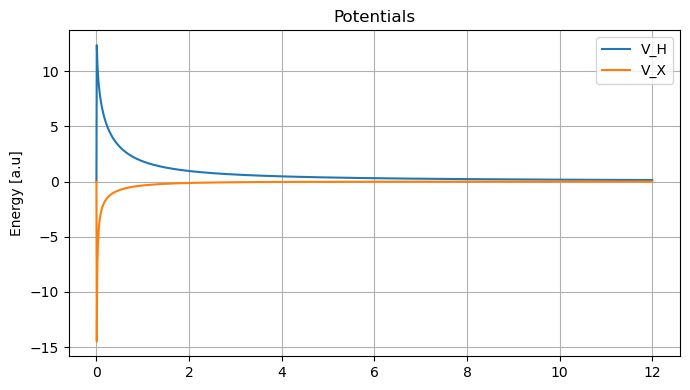

In [6]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(atom.r[atom.r<12],atom.V_H[atom.r<12],label="V_H")
ax1.plot(atom.r[atom.r<12],atom.V_X[atom.r<12],label="V_X")
ax1.set(title='Potentials',ylabel= 'Energy [a.u]')
ax1.legend(loc = 'upper right')
ax1.grid()
fig.tight_layout()
plt.show()
